http://xarray.pydata.org/en/stable/auto_gallery/plot_rasterio.html

In [1]:
%matplotlib inline



=================================
Parsing rasterio's geocoordinates
=================================


Converting a projection's cartesian coordinates into 2D longitudes and
latitudes.

These new coordinates might be handy for plotting and indexing, but it should
be kept in mind that a grid which is regular in projection coordinates will
likely be irregular in lon/lat. It is often recommended to work in the data's
original map projection (see `recipes.rasterio_rgb`).



In [9]:
import os
import urllib.request

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import transform

import xarray as xr

# Download the file from rasterio's repository
#url = 'https://github.com/mapbox/rasterio/raw/master/tests/data/RGB.byte.tif'
#urllib.request.urlretrieve(url, 'RGB.byte.tif')

In [3]:
# Read the data
da = xr.open_rasterio('RGB.byte.tif')

# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])

In [4]:
da

<xarray.DataArray (band: 3, y: 718, x: 791)>
[1703814 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 2.827e+06 2.826e+06 2.826e+06 2.826e+06 2.826e+06 ...
  * x        (x) float64 1.021e+05 1.024e+05 1.027e+05 1.03e+05 1.033e+05 ...
Attributes:
    transform:   (300.0379266750948, 0.0, 101985.0, 0.0, -300.041782729805, 2...
    crs:         +init=epsg:32618
    res:         (300.0379266750948, 300.041782729805)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0)

In [5]:
x, y = np.meshgrid(da['x'], da['y'])

In [11]:
x.shape

(718, 791)

In [6]:
# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

In [7]:
da

<xarray.DataArray (band: 3, y: 718, x: 791)>
[1703814 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 2.827e+06 2.826e+06 2.826e+06 2.826e+06 2.826e+06 ...
  * x        (x) float64 1.021e+05 1.024e+05 1.027e+05 1.03e+05 1.033e+05 ...
    lon      (y, x) float64 -78.96 -78.95 -78.95 -78.95 -78.95 -78.94 -78.94 ...
    lat      (y, x) float64 25.5 25.5 25.5 25.51 25.51 25.51 25.51 25.51 ...
Attributes:
    transform:   (300.0379266750948, 0.0, 101985.0, 0.0, -300.041782729805, 2...
    crs:         +init=epsg:32618
    res:         (300.0379266750948, 300.041782729805)
    is_tiled:    0
    nodatavals:  (0.0, 0.0, 0.0)

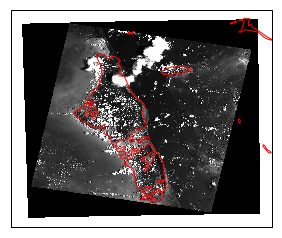

In [8]:
# Compute a greyscale out of the rgb image
greyscale = da.mean(dim='band')

# Plot on a map
ax = plt.subplot(projection=ccrs.PlateCarree())
greyscale.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap='Greys_r', add_colorbar=False)
ax.coastlines('10m', color='r')
plt.show()

# Delete the file
#os.remove('RGB.byte.tif')